# Análise de Precisão de Estimativas do Sistema PlaninfraWeb
Esta análise tem como objetivo avaliar a precisão das estimativas de projetos cadastrados no sistema PlaninfraWeb,
comparando valores estimados versus valores efetivamente projetados, identificando erros e variações por ano e por
responsável técnico.
### **1. Importações e configuração inicial**
Aqui são carregadas as bibliotecas necessárias.

In [6]:
# Pacotes essenciais
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')


### **2. Carregando os dados**
Nesta seção, é utilizada a função `pd.read_csv` para carregar a base de dados em um data frame pandas.

In [7]:
try:
    df_bruto = pd.read_csv('data.csv')
except Exception as e:
    print(f"Erro: {e}")
    sys.exit(1)


### **3. Limpando e filtrando os dados**
Neste item são realizados:
- a padronização de valores numéricos,
- a remoção de `NaN`, e
- os ajustes de formato para análise posterior.

In [8]:
df = df_bruto[['ID Planinfra','Ano de entrada','VALOR ESTIMATIVA (R$)','VALOR PROJETO  (R$)','RESPONSÁVEL ETPE']]
df = df[df['VALOR ESTIMATIVA (R$)'].notna()]
cols = ['VALOR ESTIMATIVA (R$)','VALOR PROJETO  (R$)']

for col in cols:
    df[col] = df[col].str.replace('R$ ','').str.replace('.','').str.replace(',','.')
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['Ano de entrada'] = pd.to_numeric(df['Ano de entrada'], errors = 'coerce')

df = df[df['VALOR ESTIMATIVA (R$)'].notna()]
df = df[df['VALOR PROJETO  (R$)'].notna()]
df = df[df['VALOR PROJETO  (R$)'] != df['VALOR ESTIMATIVA (R$)']]
df = df[(df['VALOR PROJETO  (R$)'] > 1) & (df['VALOR ESTIMATIVA (R$)'] > 1)]

df = df.rename(columns={'VALOR ESTIMATIVA (R$)':'estimativa', 'Ano de entrada':'ano','VALOR PROJETO  (R$)':'projeto'})
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 278 entries, 13 to 1350
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID Planinfra      278 non-null    object 
 1   ano               278 non-null    int64  
 2   estimativa        278 non-null    float64
 3   projeto           278 non-null    float64
 4   RESPONSÁVEL ETPE  132 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 13.0+ KB


### **4. Visualizando os dados**
#### **4.1 Estatíticas Descritivas e visão geral do data frame**
##### Estatísticas descritivas

In [9]:
df.describe()


,ano,estimativa,projeto
count,278.000000,2.780000e+02,2.780000e+02
mean,2021.906475,5.298120e+06,5.748518e+06
std,1.867031,1.172920e+07,1.259508e+07
min,2018.000000,8.260000e+03,4.469000e+04
25%,2020.000000,4.725000e+05,5.385633e+05
50%,2022.000000,1.362400e+06,1.754941e+06
75%,2023.000000,4.750499e+06,5.264849e+06
max,2025.000000,1.050000e+08,1.148098e+08


##### Visão geral

In [10]:
df.head()

,ID Planinfra,ano,estimativa,projeto,RESPONSÁVEL ETPE
13,2018-1014,2018,3110154.39,5017767.83,NaN
46,2018-1047,2018,5053512.36,5169514.93,NaN
57,2018-1058,2018,8700000.00,10008857.49,NaN
71,2019-1072,2019,3380461.13,5075337.45,NaN
73,2019-1074,2019,3000000.00,5520395.90,NaN


#### **4.2 Visualização do histograma dos valores estimados e dos valores verificados após o projeto**


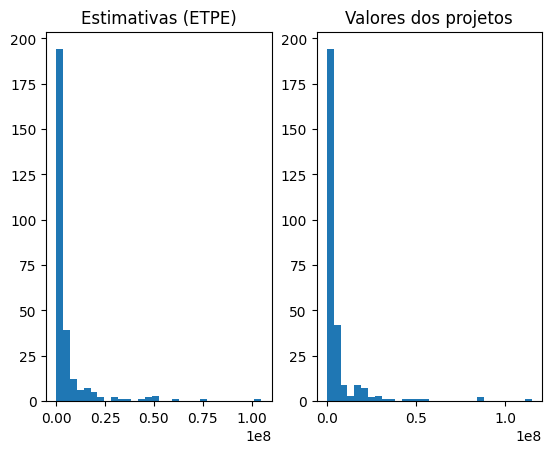

In [11]:
fig, ax = plt.subplots(1,2)
ax[0].hist(df['estimativa'], bins=30)
ax[0].set_title('Estimativas (ETPE)')
ax[1].hist(df['projeto'], bins=30)
ax[1].set_title('Valores dos projetos')
plt.show()


### **5. Calculando o erro e visualizando seu gráfico de dispersão**

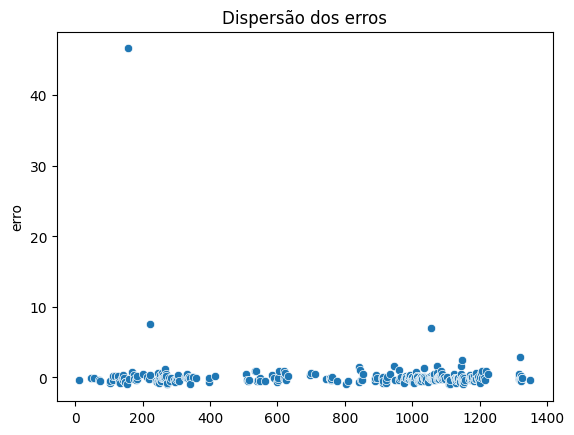

In [12]:
df['erro'] = (df['estimativa']/df['projeto']) - 1

df.describe()

sns.scatterplot(data=df, x=df.index, y='erro')
plt.title('Dispersão dos erros')
plt.xlabel('')
plt.show()



Verifica-se pelo gráfico de dispersão acima que claramente existem valores discrepantes e que devem ser tratados. 
As discrepâncias são frutos de duas fontes principais:
- Erros de inserção manual no sistema
- Aletração de escopo entre o estudo técnico preliminar e o projeto

Abaixo esses outliers serão tratados.

### **6. Tratando os outliers**
#### **6.1 Escolhendo a melhor estratégia**

In [13]:
# Função para detectar outliers via IQR
def is_outlier_iqr(data):
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    upper_bound = np.percentile(data, 75) + 1.5*iqr 
    lower_bound = np.percentile(data, 25) - 1.5*iqr
    return (data > upper_bound) | (data < lower_bound)

# Contando quantos outliers existem
n_outliers = df[is_outlier_iqr(df['erro'])]['ID Planinfra'].count()

# Calculando a proporção de outliers
n_outliers/len(df)

0.046762589928057555

Como os valores tidos como outliers usando o método IQR são inferiores a 5% da população em análise, optou-se simplesmente por descartá-los.

#### 6.2 **Removendo os outliers e visualizando a nova dispersão e a distribuição dos erros**

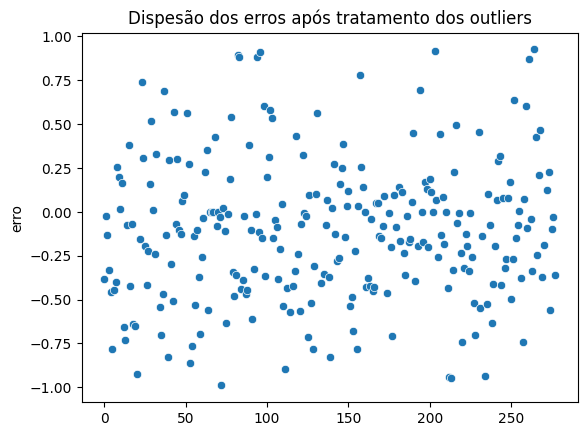

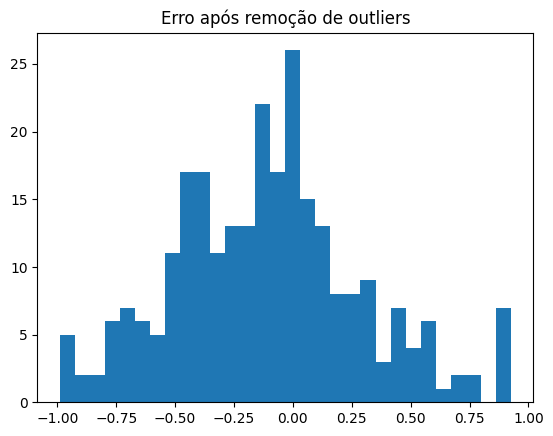

In [14]:
df = df.reset_index()
df = df[~is_outlier_iqr(df['erro'])]

sns.scatterplot(data=df, x=df.index, y='erro')
plt.xlabel('')
plt.title('Dispesão dos erros após tratamento dos outliers')
plt.show()

plt.hist(df['erro'], bins=30)
plt.title('Erro após remoção de outliers')
plt.show()


Nota-se que os erros ficaram mais concentrados e com uma distribuição semelhante a uma normal (gaussiana).

### **7. Cálculo do MAPE por ano**

O MAPE (Erro Percentual Absoluto Médio) é uma métrica amplamente utilizada para avaliar a acurácia de previsões. Neste contexto, ele nos mostra o quão distante, em média, os valores estimados estão dos valores reais dos projetos.

Será feita uma análise da evolução anual do MAPE.

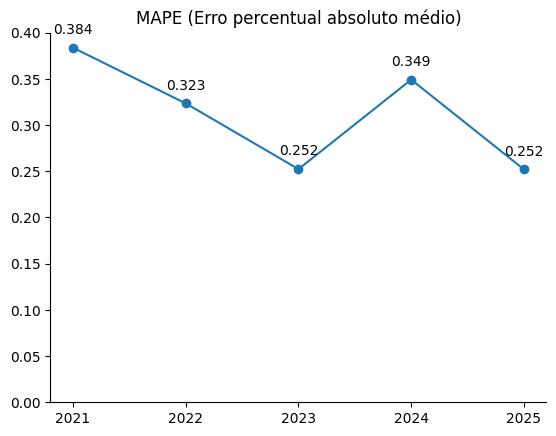

In [15]:
mape = {}

for ano in range (2021,2026):
    tmp = df[df['ano'] == ano]
    mape[ano] = np.abs(tmp['erro']).sum()/len(tmp['erro'].values)
        
x = list(mape.keys())
y = list(mape.values())
plt.plot(mape.keys(),mape.values(), marker='o')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0,0.4)
for i in range(len(x)):
    plt.text(x[i], y[i]+0.015, str(y[i].round(3)), ha='center')
    plt.title('MAPE (Erro percentual absoluto médio)')
plt.xticks(x)
plt.show()


Nota-se uma tendência de diminuição do MAPE com o decorrer dos anos, mostrando uma evolução na maturidade do processo de estimativa dos custos.

### **8. Precisão das estimativas**

A Ordem Técnica nº 004/2012 do IBRAOP estabelece uma variação de ±30% como margem de precisão aceitável para estimativas de custos em estudos preliminares. 


Portanto, será verificado quantas estimativas, ano a ano, atenderam a esse critério.

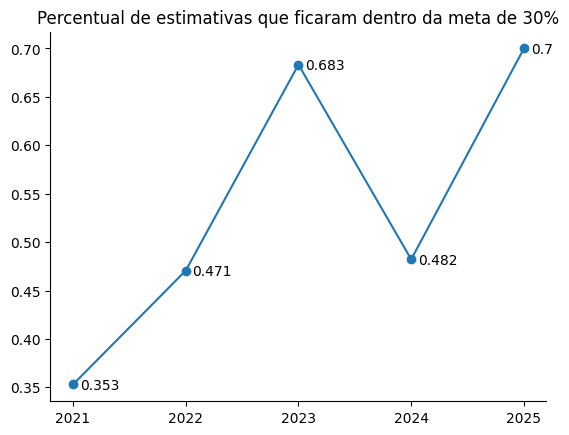

In [16]:
prec = {}

for ano in range (2021,2026):
    tmp = df[df['ano'] == ano]
    prec[ano] = (np.abs(tmp['erro']) <= 0.3).sum()/len(tmp['erro'].values)
    
plt.plot(prec.keys(),prec.values(), marker = 'o')
plt.title('Percentual de estimativas que ficaram dentro da meta de 30%')
plt.xticks(list(prec.keys()))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
for i in range(len(prec.keys())):
    plt.text(list(prec.keys())[i]+0.06, list(prec.values())[i]-0.005, str(list(prec.values())[i].round(3)), ha='left')
plt.show() 


Apesar de uma queda em 2024, observa-se um aumento progressivo no número de estimativas que se enquadram nessa faixa de precisão.

### **9. Estudo por elos (Responsáveis)**

De modo a verificar se algum elo possui um melhor desempenho nas estimativas, será feita uma análsie agrupando-se os resultados por elo.

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 89 to 277
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RESPONSÁVEL ETPE  126 non-null    object 
 1   ano               126 non-null    int64  
 2   erro              126 non-null    float64
 3   erro_abs          126 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.9+ KB


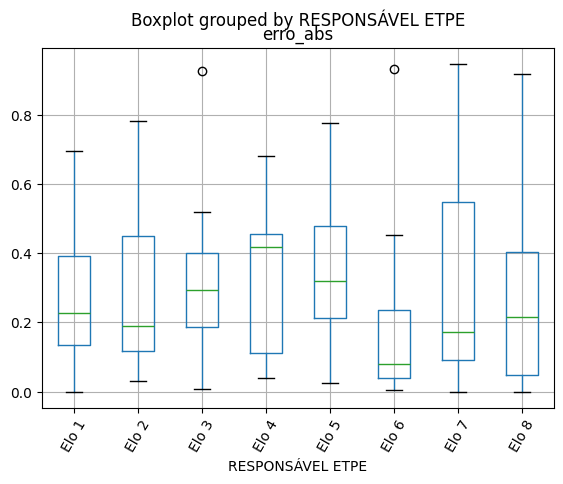

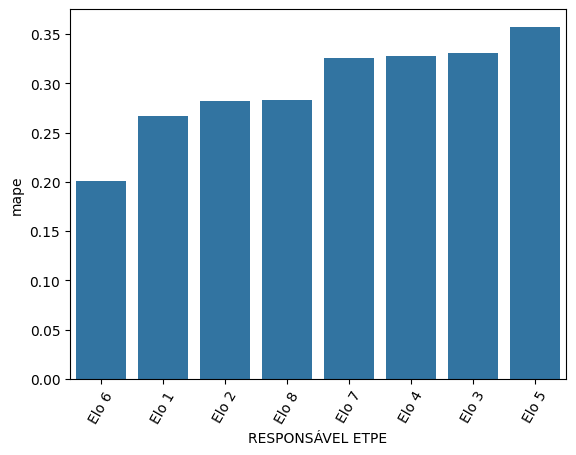

In [17]:
df_elos = df[df['RESPONSÁVEL ETPE'].notna()].copy()
df_elos = df_elos[['RESPONSÁVEL ETPE','ano','erro']]
df_elos['erro_abs'] = abs(df_elos['erro'])
df_elos.info()
def mape(x):
    output = np.abs(x['erro']).sum()/len(x)
    return output
df_group = df_elos.groupby(['RESPONSÁVEL ETPE']).apply(
    lambda x: pd.Series({
        'mape': np.abs(x['erro']).sum() / len(x),
        'contagem': len(x)
    })
)
df_group = df_group.sort_values('mape', ascending=True)

# Visualizando boxplots
df_elos.boxplot(column = 'erro_abs', by='RESPONSÁVEL ETPE')
plt.xticks(rotation=60)
plt.show()

sns.barplot(data=df_group, x='RESPONSÁVEL ETPE', y='mape')
plt.xticks(rotation=60)
plt.show()


Nota-se que o elo com menor performance apresentou um MAPE de 20%, enquanto o elo com maior performance apresentou um MAPE de quase 35%.

### **10. Teste estatístico Mann-Whitney U Test**

Para investigar se há diferença estatisticamente significativa entre os erros percentua absolutos médios entre os elos2)será utilizadoos o teste de **Mann-Whitney U**

Este teste é uma alternativa não-paramétrica ao teste t de Student, ideal para comparar **duas distribuições independentes** quando não se pode assumir normalidade nos dads.

### Hipóteses:
- **H₀ (hipótese nula):** As distribuições dos dois grupos são iguais (não há diferença significativa entre os grupos).
- **H₁ (hipótese alternativa):** As distribuições dos dois grupos são diferentes (há diferença significativa entre os gupos).

O teste será aplicado ao MAPE (Mean Absolute Percentage Error), nossa métrica principal de erro.


H = 159.0000, p-valor = 0.0101
Diferença estatisticamente significante a um nível de significância de 5%!


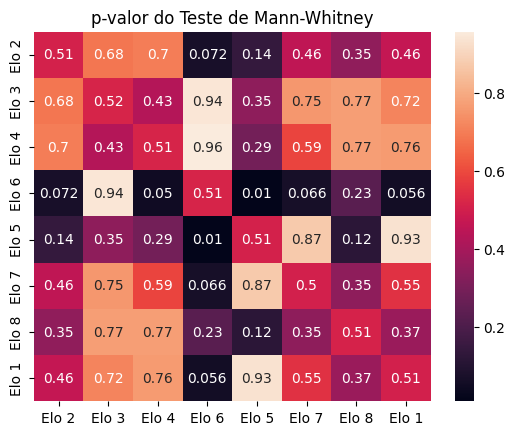

In [22]:
# Teste Mann-Whitney U Test (ou Wilcoxon Rank-Sum Test) para verificar se as diferenças entre os MAPEs são significantes entre os elos
mw_dict = {}
elos = df_elos['RESPONSÁVEL ETPE'].unique()
for elo in elos:
    mw_dict[elo] = df_elos[df_elos['RESPONSÁVEL ETPE']==elo]
    

# Aplicando o teste Mann-Whitney U Test (ou Wilcoxon Rank-Sum Test) entre os elos 5 e 6
mw_stat, mw_pvalue = mannwhitneyu(mw_dict['Elo 5']['erro_abs'], mw_dict['Elo 6']['erro_abs'], alternative='greater')
    
print(f'H = {mw_stat:.4f}, p-valor = {mw_pvalue:.4f}')

# Diagnóstico:
sigf_lev = 0.05
if mw_pvalue < sigf_lev:
    print(f"Diferença estatisticamente significante a um nível de significância de {int(100*sigf_lev)}%!")
else:
    print(f"Sem diferença significativa a um nível de significância de {int(100*sigf_lev)}%.")
    
# Criando uma matriz de p-valor comparando a diferença entre o erro absoluto médio entre os elos
mw_matriz = pd.DataFrame(columns=elos, index=elos)

for index, row in mw_matriz.iterrows():
    for col in mw_matriz.columns:
        if len(mw_dict[index]) > len(mw_dict[col]):
            alternative = 'greater'
        else:
            alternative = 'less'
        row[col] = mannwhitneyu(mw_dict[index]['erro_abs'], mw_dict[col]['erro_abs'], alternative=alternative)[1]


mw_matriz = mw_matriz.apply(pd.to_numeric, errors='coerce')
    
sns.heatmap(mw_matriz, annot=True)
plt.title('p-valor do Teste de Mann-Whitney')
plt.show()

Pela matriz, verifica-se que existem muitos p-valores que não descartam a hipótese nula. Isso se deve principalmente a uma pequena quantidade de observações para alguns elos.

### **11. Conclusões**
- Observou-se que, em 2025, 70% das estimativas estão dentro da margem de 30%, margem aceitável para estimativas preliminares de custos conforme Ordem Técnica n° 004/2012. Observou-se uma clara evolução com relação com relação aos valores apurados nos anos anteriores.
- Além disso o MAPE em 2025, 25,2%, também foi o menor verificado no período de análise, mostrando um amadurecimento do processo de estimativa.
- Sugere-se revisão de processos de estimativa para os elos com maior MAPE, com base nos metodologias adotadas por aqueles que possuem menor MAPE.